In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/top-movies/movies.csv
/kaggle/input/ratings/ratings.csv


In [3]:
movie_data = pd.read_csv('../input/top-movies/movies.csv')
rating_data= pd.read_csv('../input/ratings/ratings.csv')

In [4]:
movie_data.describe()
# movie_data.head()
# rating_data.describe()
# rating_data.head()

,movieId
count,10329.000000
mean,31924.282893
std,37734.741149
min,1.000000
25%,3240.000000
50%,7088.000000
75%,59900.000000
max,149532.000000


# Data Pre-Processing

In [5]:
# One-hot encoding genre
splitted_strings = [words.split('|') for words in movie_data['genres']]

list_genre = ["Action", "Adventure", "Animation", "Children", 
                "Comedy", "Crime","Documentary", "Drama", "Fantasy",
                "Film-Noir", "Horror", "Musical", "Mystery","Romance",
                "Sci-Fi", "Thriller", "War", "Western"]
genre_dataframe = pd.DataFrame(np.zeros((10329,18)),columns = list_genre)

for row_index,genre_row in enumerate(splitted_strings):
    for col_index,genre in enumerate(genre_row):
        if genre in list_genre:
            genre_dataframe[genre][row_index]=1


In [6]:
#combine data
genre_dataframe = genre_dataframe.astype(int)
movie_data = pd.concat([movie_data.iloc[:,0:2],genre_dataframe],axis=1)
movie_data


,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10324,146684,Cosmic Scrat-tastrophe (2015),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10325,146878,Le Grand Restaurant (1966),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10326,148238,A Very Murray Christmas (2015),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10327,148626,The Big Short (2015),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


### Explore Similar Data

In [7]:

movie_rating = rating_data.pivot_table(index="userId", 
                    columns='movieId', 
                    values='rating').reset_index()
movie_rating = movie_rating.drop(['userId'],axis=1)
movie_rating.columns.name=None
movie_rating = movie_rating.fillna(0)

from sklearn.metrics.pairwise import cosine_similarity

users_similarities = cosine_similarity(movie_rating.iloc[0:4])
movies_similarities = cosine_similarity(movie_rating.iloc[:,0:4].T)

unique_data = rating_data['rating'].value_counts()
unique_data


4.0    28880
3.0    21729
5.0    14856
3.5    12237
4.5     8187
2.0     7943
2.5     5484
1.0     3258
1.5     1567
0.5     1198
Name: rating, dtype: int64

# Most Viewed Movies Visualization

In [8]:
movie_views = rating_data.groupby('movieId')['rating'].count().reset_index()
movie_views = movie_views.rename(columns={'rating':'views'})
movie_views = pd.merge(movie_views, movie_data.iloc[:,0:2], on="movieId")


In [9]:
top_10_movies = movie_views.sort_values(['views'],ascending = False).iloc[0:10]
top_10_movies

,movieId,views,title
260,296,325,Pulp Fiction (1994)
316,356,311,Forrest Gump (1994)
279,318,308,"Shawshank Redemption, The (1994)"
426,480,294,Jurassic Park (1993)
525,593,290,"Silence of the Lambs, The (1991)"
230,260,273,Star Wars: Episode IV - A New Hope (1977)
2056,2571,261,"Matrix, The (1999)"
522,589,253,Terminator 2: Judgment Day (1991)
471,527,248,Schindler's List (1993)
98,110,248,Braveheart (1995)


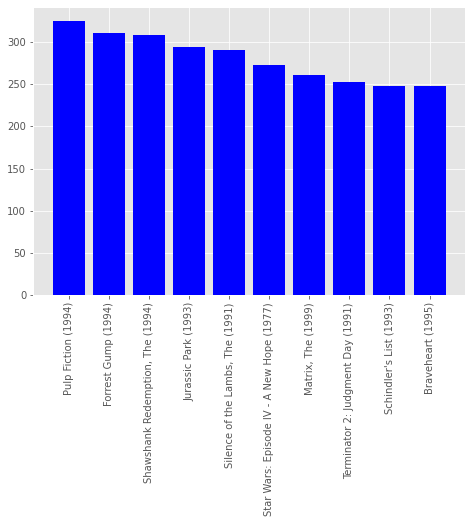

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')  # optional: for ggplot-like style

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
title = top_10_movies['title']
views = top_10_movies['views']
ax.bar(title,views,color = 'b')
plt.xticks(rotation=90)
plt.show()

# Perform Data Preparation

In [11]:
# Filter out left only minumum movie view or user ratings > 50
movies_rating_after_threshold = movie_rating.loc[(((movie_rating>0).sum(axis=1))>50).to_numpy(),(((movie_rating>0).sum(axis=0))>50).to_numpy()]
movies_rating_after_threshold


,1,2,3,5,6,7,10,11,16,17,...,59315,60069,63082,68157,68358,68954,69122,70286,72998,79132
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,3.0,0.0,3.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,5.0,0.0,0.0,1.5,4.0,0.0
664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.5,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


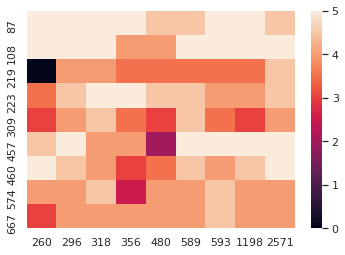

In [12]:
# top 2% most active users ratings on top 2% most viewed movies
import seaborn as sns
sns.set_theme()

df1 = (movies_rating_after_threshold>0).sum(axis=1).to_frame()
quantile_98_percent_active_users = df1.quantile(.98, axis = 0)
df2 = (movies_rating_after_threshold>0).sum(axis=0).to_frame()
quantile_98_percent_popular_movies = df2.quantile(.98, axis = 0)

top_98 = movies_rating_after_threshold.loc[(((movies_rating_after_threshold>0).sum(axis=1))>int(quantile_98_percent_active_users)).to_numpy(),(((movies_rating_after_threshold>0).sum(axis=0))>int(quantile_98_percent_popular_movies)).to_numpy()]
ax = sns.heatmap(top_98)

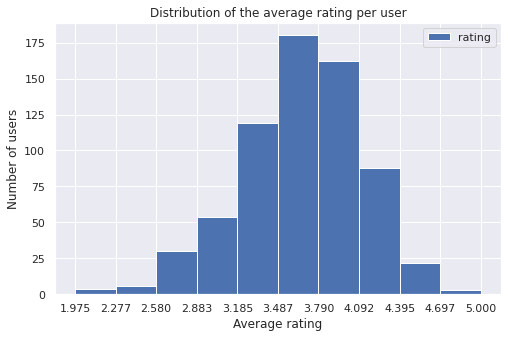

In [13]:
# Histogram of average rating per user
average_ratings = rating_data.groupby('userId')['rating'].mean().reset_index()
average_ratings = average_ratings.drop('userId',axis=1)

count, bin_edges = np.histogram(average_ratings)
average_ratings.plot(kind='hist', figsize=(8, 5),xticks = bin_edges)

# add a title to the histogram
plt.title('Distribution of the average rating per user')
# add y-label
plt.ylabel('Number of users')
# add x-label
plt.xlabel('Average rating')

plt.show()

### Data Normalization

In [14]:
movies_rating_nan = movies_rating_after_threshold.replace({0:np.nan})
normalized_ratings = movies_rating_nan.subtract(movies_rating_nan.mean(axis=1),axis=0)
normalized_ratings


,1,2,3,5,6,7,10,11,16,17,...,59315,60069,63082,68157,68358,68954,69122,70286,72998,79132
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.153409,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,-0.680000,NaN,-0.680000,NaN,0.320000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.239130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.239130,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.741935,NaN,NaN,NaN,-0.258065,-1.258065,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.011628,NaN,1.011628,NaN,NaN,-2.488372,0.011628,NaN
664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Performing Data Binarization

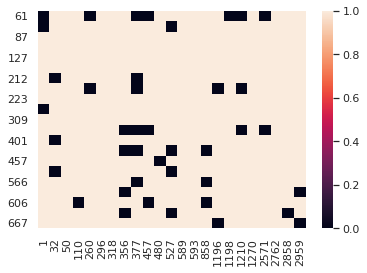

In [15]:
binarized_movies_rating_with_nan = movies_rating_nan.replace({0.5:0,1:0,1.5:0,2:0,2.5:0,3:1,3.5:1,4:1,4.5:1,5.:1})
binarized_movies_rating = movies_rating_nan.ge(3).astype(int)
quantile_95_percent_active_users = df1.quantile(.95, axis = 0)
quantile_95_percent_popular_movies = df2.quantile(.95, axis = 0)

top_95 = binarized_movies_rating.loc[((binarized_movies_rating_with_nan.count(axis=1))>int(quantile_95_percent_active_users)).to_numpy(),((binarized_movies_rating_with_nan.count(axis=0))>int(quantile_95_percent_popular_movies)).to_numpy()]
ax = sns.heatmap(top_95)


# Build Movie Recommender

In [37]:
from sklearn.neighbors import NearestNeighbors

In [16]:
ratings2 = pd.merge(rating_data, movie_data, how='inner', on='movieId')
df= ratings2.pivot_table(index='title',columns='userId',values='rating').fillna(0) #pivot table summarize the duplicate movies name 
df1 = df.copy()

# pd.merge(rating_data, movie_data, how='outer', on='movieId',indicator=True).loc[lambda x : x['_merge']=='right_only']
# this line is able to find where there is no matching movieId in the rating_data dataframe

In [ ]:
# find the nearest neighbors using NearestNeighbors(n_neighbors=3)
number_neighbors = 3
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(df.values)
distances, indices = knn.kneighbors(df.values, n_neighbors=number_neighbors)

# copy df
df1 = df.copy()

# convert user_name to user_index
user_index = df.columns.tolist().index(10)

# t: movie_title, m: the row number of t in df
for m,t in list(enumerate(df.index)):
  
    print(m)
    print(t)
    # find movies without ratings by user_4
    if df.iloc[m, user_index] == 0:
        #remember m is row
        sim_movies = indices[m].tolist() # get the row of the similarity from similarity matrix
        movie_distances = distances[m].tolist() # get the row of the distance from distances matrix
        print(type(sim_movies))
        print(type(movie_distances))
    
    # Generally, this is the case: indices[3] = [3 6 7]. The movie itself is in the first place.
    # In this case, we take off 3 from the list. Then, indices[3] == [6 7] to have the nearest NEIGHBORS in the list. 
        if m in sim_movies:
            id_movie = sim_movies.index(m)
            sim_movies.remove(m)
            movie_distances.pop(id_movie)


    # However, if the percentage of ratings in the dataset is very low, there are too many 0s in the dataset. 
    # Some movies have all 0 ratings and the movies with all 0s are considered the same movies by NearestNeighbors(). 
    # Then,even the movie itself cannot be included in the indices. 
    # For example, indices[3] = [2 4 7] is possible if movie_2, movie_3, movie_4, and movie_7 have all 0s for their ratings.
    # In that case, we take off the farthest movie in the list. Therefore, 7 is taken off from the list, then indices[3] == [2 4].
        else:
            sim_movies = sim_movies[:number_neighbors-1]
            movie_distances = movie_distances[:number_neighbors-1]
        
    # movie_similarty = 1 - movie_distance    
    movie_similarity = [1-x for x in movie_distances]
    movie_similarity_copy = movie_similarity.copy()
    nominator = 0

    # for each similar movie
    # this part is for calculating the numerator part of the formula: sum of actual rating times similarity
    for s in range(0, len(movie_similarity)):
      
      # check if the rating of a similar movie is zero
        if df.iloc[sim_movies[s], user_index] == 0:

        # if the rating is zero, ignore the rating and the similarity in calculating the predicted rating
            if len(movie_similarity_copy) == (number_neighbors - 1):
                movie_similarity_copy.pop(s)
          
            else:
                #If the second movie similarity is also zero then:
                movie_similarity_copy.pop(s-(len(movie_similarity)-len(movie_similarity_copy)))

      # if the rating is not zero, use the rating and similarity in the calculation
        else:
            nominator = nominator + movie_similarity[s]*df.iloc[sim_movies[s],user_index]

    # check if the number of the ratings with non-zero is positive
    # this part is for calculating denominator part of the formula : sum of similarity then produce the predicted
    # rating through division
    if len(movie_similarity_copy) > 0:
      
      # check if the sum of the ratings of the similar movies is positive.
        if sum(movie_similarity_copy) > 0:
            predicted_r = nominator/sum(movie_similarity_copy)

      # Even if there are some movies for which the ratings are positive, some movies have zero similarity even though they are selected as similar movies.
      # in this case, the predicted rating becomes zero as well  
        else:
            predicted_r = 0

    # if all the ratings of the similar movies are zero, then predicted rating should be zero
    else:
        predicted_r = 0

  # place the predicted rating into the copy of the original dataset
    df1.iloc[m,user_index] = predicted_r


### Recommend similar movies by selecting movie

### Recommend movies for a selected user

In [38]:
def recommend_movies(user, num_recommended_movies):

    print('The list of the Movies {} Has Watched \n'.format(user))


    for m in df[df[user] > 0][user].index.tolist():

        print(m)
        print('\n')

    recommended_movies = []

    for m in df[df[user] == 0].index.tolist():

        index_df = df.index.tolist().index(m)
        predicted_rating = df1.iloc[index_df, df1.columns.tolist().index(user)]
        recommended_movies.append((m, predicted_rating))

    sorted_rm = sorted(recommended_movies, key=lambda x:x[1], reverse=True)
  
    print('The list of the Recommended Movies \n')
    rank = 1
    for recommended_movie in sorted_rm[:num_recommended_movies]:
    
        print('{}: {} - predicted rating:{}'.format(rank, recommended_movie[0], recommended_movie[1]))
        rank = rank + 1

In [39]:
# copy df
df1 = df.copy()
def movie_recommender(user, num_neighbors, num_recommendation) :  
    # find the nearest neighbors using NearestNeighbors(n_neighbors=3)
    number_neighbors = 3
    knn = NearestNeighbors(metric='cosine', algorithm='brute')
    knn.fit(df.values)
    distances, indices = knn.kneighbors(df.values, n_neighbors=number_neighbors)

    # convert user_name to user_index
    user_index = df.columns.tolist().index(user)

    # t: movie_title, m: the row number of t in df
    for m,t in list(enumerate(df.index)):

      # find movies without ratings by user_4
        if df.iloc[m, user_index] == 0:
            sim_movies = indices[m].tolist()
            movie_distances = distances[m].tolist()

            # Generally, this is the case: indices[3] = [3 6 7]. The movie itself is in the first place.
            # In this case, we take off 3 from the list. Then, indices[3] == [6 7] to have the nearest NEIGHBORS in the list. 
            if m in sim_movies:
                id_movie = sim_movies.index(m)
                sim_movies.remove(m)
                movie_distances.pop(id_movie) 

            # However, if the percentage of ratings in the dataset is very low, there are too many 0s in the dataset. 
            # Some movies have all 0 ratings and the movies with all 0s are considered the same movies by NearestNeighbors(). 
            # Then,even the movie itself cannot be included in the indices. 
            # For example, indices[3] = [2 4 7] is possible if movie_2, movie_3, movie_4, and movie_7 have all 0s for their ratings.
            # In that case, we take off the farthest movie in the list. Therefore, 7 is taken off from the list, then indices[3] == [2 4].
            else:
                sim_movies = sim_movies[:number_neighbors-1]
                movie_distances = movie_distances[:number_neighbors-1]

        # movie_similarty = 1 - movie_distance    
        movie_similarity = [1-x for x in movie_distances]
        movie_similarity_copy = movie_similarity.copy()
        nominator = 0

        # for each similar movie
        for s in range(0, len(movie_similarity)):

          # check if the rating of a similar movie is zero
            if df.iloc[sim_movies[s], user_index] == 0:

                # if the rating is zero, ignore the rating and the similarity in calculating the predicted rating
                if len(movie_similarity_copy) == (number_neighbors - 1):
                    movie_similarity_copy.pop(s)

                else:
                    movie_similarity_copy.pop(s-(len(movie_similarity)-len(movie_similarity_copy)))

              # if the rating is not zero, use the rating and similarity in the calculation
            else:
                nominator = nominator + movie_similarity[s]*df.iloc[sim_movies[s],user_index]

        # check if the number of the ratings with non-zero is positive
        if len(movie_similarity_copy) > 0:

            # check if the sum of the ratings of the similar movies is positive.
            if sum(movie_similarity_copy) > 0:
                predicted_r = nominator/sum(movie_similarity_copy)

            # Even if there are some movies for which the ratings are positive, some movies have zero similarity even though they are selected as similar movies.
            # in this case, the predicted rating becomes zero as well  
            else:
                predicted_r = 0

        # if all the ratings of the similar movies are zero, then predicted rating should be zero
        else:
            predicted_r = 0

        # place the predicted rating into the copy of the original dataset
        df1.iloc[m,user_index] = predicted_r
    recommend_movies(user, num_recommendation)

In [40]:
movie_recommender(15, 10, 10)

The list of the Movies 15 Has Watched 

Adventures of Baron Munchausen, The (1988)


Akira Kurosawa's Dreams (Dreams) (1990)


American Psycho (2000)


Around the World in 80 Days (1956)


Beetlejuice (1988)


Blade Runner (1982)


Bottle Rocket (1996)


Brazil (1985)


Cabinet of Dr. Caligari, The (Cabinet des Dr. Caligari., Das) (1920)


Casino Royale (2006)


Cell, The (2000)


City Lights (1931)


Clockwork Orange, A (1971)


Crimson Peak (2015)


Cronos (1993)


Darjeeling Limited, The (2007)


Dark Star (1974)


Devil's Backbone, The (Espinazo del diablo, El) (2001)


Django Unchained (2012)


Double Indemnity (1944)


Dr. Horrible's Sing-Along Blog (2008)


Dracula (1931)


Ed Wood (1994)


Eyes Without a Face (Yeux sans visage, Les) (1959)


Fantastic Mr. Fox (2009)


Fear and Loathing in Las Vegas (1998)


Fight Club (1999)


Flesh and the Devil (1926)


Godzilla (Gojira) (1954)


Grand Budapest Hotel, The (2014)


Grand Hotel (1932)


Haunting, The (1963)


Hellboy (2004)


H

# Conclusion

This item-based collaborative filtering movie recommendation is done by as follow points:

* Predict the rating for the movie that hasn't been watched by a user
* Sort the predicted ratings, recommend the number of movies according to the number of recommendations request